In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(alpha=[0.5, 0.8, 1],
                                 g=[2.5, 5, 8, 10, 20])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = params['g']
g = 8
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [4]:
#Set tasks

R = 2
#alpha = params['alpha']
alpha = 0.8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                     sigma_off=0.6,
                                                                     symmetry_factor=0)
sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])

In [5]:
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

In [28]:
N_W_samples = 5
C_emp_avg = 0
S_emp_avg = 0

#lags window
dt = 0.05
T_window_emp = 120
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

S_emps = []
for i_W_sample in range(N_W_samples):
    
    print(i_W_sample)
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                         sigma_off=0.6,
                                                                         symmetry_factor=0)
    sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
    
    ### --- Estimate C empirically --- ###
    
    T_sim = 4000
    dt = 0.05
    n_T = int(T_sim/dt)
    noise_series = 0.05*np.random.normal(0, 1, (N, n_T))
    noise_series = noise_series[np.newaxis,:,:]
    noise_series = torch.from_numpy(noise_series).to(0)
    
    x, r = sample_activity(T_sim=4000, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=noise_series)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    #eta = torch.matmul(r, W_.T)
    eta = noise_series.squeeze().T[int(200/0.05):]
    phi_ft = uni_rfft(r.T, dt, dim=1)
    eta_ft = uni_rfft(eta.T, dt, dim=1)
    C_eta_ft = uni_corr(eta_ft, eta_ft, dt, dim=1).mean(0)
    C_phi_eta_ft = uni_corr(phi_ft, eta_ft, dt, dim=1).mean(0)
    C_eta_ft[C_eta_ft == 0] = np.nan
    S_ft = uni_conv(C_phi_eta_ft, uni_inv(C_eta_ft))
    S_ft[torch.isnan(S_ft)] = 0.0
    S = uni_irfft(S_ft, dt)
    S_emp = S.cpu().numpy()
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    S_emps.append(S_emp)
    C_emp_avg += C_emp / N_W_samples
    S_emp_avg += S_emp[:len(C_emp)] / N_W_samples

0


In [23]:
eta_ft.shape

torch.Size([5000, 38001])

(0.0, 100.0)

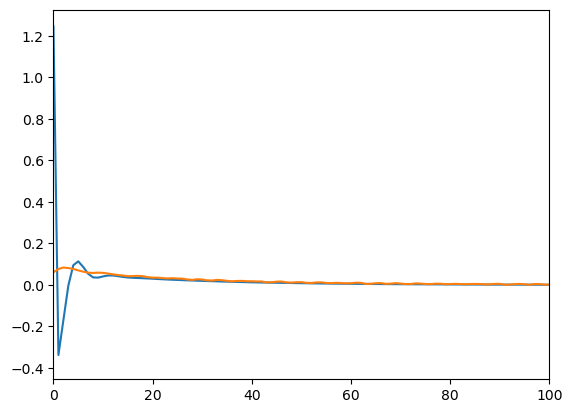

In [11]:
for i in range(1):    
    plt.plot(S_emps[i])
    plt.plot(S_numpy)
plt.xlim([0,100])

(0.0, 100.0)

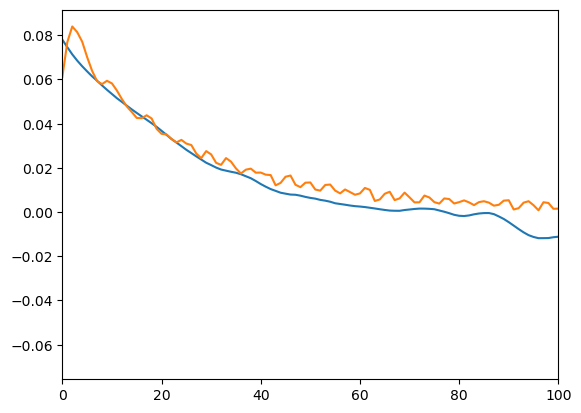

In [29]:
for i in range(1):    
    plt.plot(S_emps[i])
    plt.plot(S_numpy)
plt.xlim([0,100])

In [6]:
### --- Set theory parameters --- ###
T_window = 120
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([lags, np.array([lags[-1]]), -lags[1:][::-1]])

In [30]:
sigma_mn_all_flat = np.vstack(sigma_mn_all)
N_samples = 8000
num_iter = 40
final_avg_iter = 10
#run DMFT solver loop
C_dmft, S_dmft = util.solve_dmft(
    update_fn=(lambda C, S:
               update_extensive_tasks_2x2(torch.tensor(D).to(0),
                                          torch.tensor(sigma_mn_all_flat).to(0),
                                          C, S, N_samples=N_samples,
                                          dt=dT, alpha=params['alpha'])),
    callback_fn=None,
    init_dt=dT,
    N_t=int((2*T_window)/dT),
    num_iter=num_iter,
    device=0,
    alpha=0.8,
    final_avg_iter=final_avg_iter,
    verbose=True)

Iteration 1/40
Iteration 2/40
Iteration 3/40
Iteration 4/40
Iteration 5/40
Iteration 6/40
Iteration 7/40
Iteration 8/40
Iteration 9/40
Iteration 10/40
Iteration 11/40
Iteration 12/40
Iteration 13/40
Iteration 14/40
Iteration 15/40
Iteration 16/40
Iteration 17/40
Iteration 18/40
Iteration 19/40
Iteration 20/40
Iteration 21/40
Iteration 22/40
Iteration 23/40
Iteration 24/40
Iteration 25/40
Iteration 26/40
Iteration 27/40
Iteration 28/40
Iteration 29/40
Iteration 30/40
Iteration 31/40
Iteration 32/40
Iteration 33/40
Iteration 34/40
Iteration 35/40
Iteration 36/40
Iteration 37/40
Iteration 38/40
Iteration 39/40
Iteration 40/40


In [8]:
C_numpy = C_dmft.cpu().detach().numpy()
S_numpy = S_dmft.cpu().detach().numpy()

In [37]:
S_dmft.cpu().detach().numpy()

array([0.06239751, 0.07831857, 0.08363134, ..., 0.00023864, 0.01001198,
       0.02186351], dtype=float32)

(0.0, 200.0)

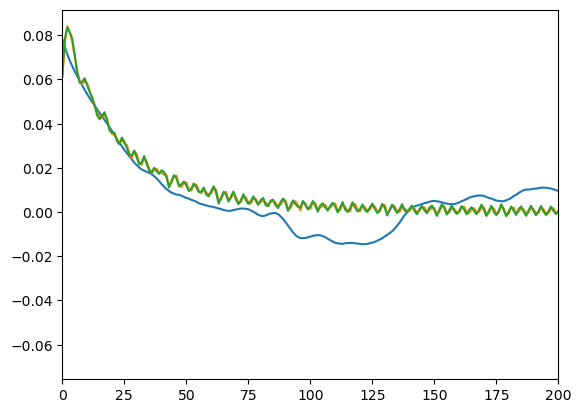

In [36]:
for i in range(1):    
    plt.plot(S_emps[i])
    plt.plot(S_numpy)
    plt.plot(S_dmft.cpu().detach().numpy().real)
plt.xlim([0,200])

In [ ]:
processed_data = np.array([S_numpy, S_emp_avg, C_numpy, C_emp_avg])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'cosyne_2024_figs'
job_name = 'double_Crr'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='misc')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='misc', lkumar=True)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'double_Crr'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='misc')

In [ ]:
job_name = 'LDR_sym_PR_match_rho_sim_final_5'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
plt.ion()

def_colors = X = plt.rcParams['axes.prop_cycle'].by_key()["color"]

plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['figure.dpi'] = 225
plt.rcParams['figure.figsize'] = [7.5/2.54, 5/2.54]
plt.rcParams['path.simplify'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.formatter.limits'] = (-3,3)

In [ ]:
theory_results[0]

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        for i_seed in range(3):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0')
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([0, 1])

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        for i_seed in range(3):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:800], color='C0')
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:800], color='C1')
            ax[i,j].set_ylim([0, 1])

In [ ]:
### --- Intensive rank task --- ###

N = 5000
R = 2
N_tasks = 1
g = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
Crr = np.array([[0.8, -0.4], [0.4, 0.8]])

W_, all_loadings = sample_W_optimized(Crr[:,:,None], D, N)
x0 = 0.5*all_loadings[0,:,2] + 0.5*all_loadings[0,:,3]
x1, r1 = sample_activity(T_sim=30, dt_save=0.01, dt=0.01, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=30*torch.from_numpy(x0[None,:]).to(0))
x2, r2 = sample_activity(T_sim=30, dt_save=0.01, dt=0.01, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=1300*torch.from_numpy(x0[None,:]).to(0))

Z1 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r1) * D[:1,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r2) * D[:1,None,None]

z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
#fig = plt.figure(figsize=(5, 5))
plt.plot([Z1[0, 0, 0]], [Z1[0, 0, 1]], marker='o', ms=3, markerfacecolor='none', color=z_color)
plt.plot(Z1[0,:2500, 0], Z1[0,:2500, 1], color=z_color)
plt.plot([Z2[0, 0, 0]], [Z2[0, 0, 1]], marker='o', ms=3, markerfacecolor='none', color=z_color)
plt.plot(Z2[0,:2500, 0], Z2[0,:2500, 1], color=z_color)

skip = 100  # interval to place arrows
length = 20
x, y = Z1[0,:2500,0], Z1[0,:2500,1]
arrow_spots = [2, 3, 10, 100, 300, 500, 700]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*1000, vy*1000, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=8, headlength=8, headaxislength=8)
x, y = Z2[0,:2500,0], Z2[0,:2500,1]
for i in [10]:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*1000, vy*1000, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=8, headlength=8, headaxislength=8)
plt.xticks([-5000, 0, 5000], ['-N', '0', 'N'])
plt.yticks([-5000, 0, 5000], ['-N', '0', 'N'])
#fig.savefig('cosyne24_figs/intensive_rank_ex.pdf', dpi=300)

In [ ]:
### --- Extensive number of tasks --- ###

smn_all = theory_results[3]['0.8_8_0']
#smn_all_changed = smn_all.copy()
#smn_all_changed[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.1 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=10)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z1 = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r1) * D[:5,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]

z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 120
T_steps_show = int(T_show/0.05)
plt.plot(Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*5, vy*5, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xticks([-25, 0, 25])
plt.yticks([-25, 0, 25])

In [ ]:
fig.savefig('cosyne24_figs/extensive_rank_ex.pdf', dpi=300)

In [ ]:
### --- DMFT Example --- ###

D2Cphi = D[0]**2 * C
C_rr = torch.tensor(smn_all[:,:,0], dtype=torch.float32).to(0)
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, 0.05)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
for i_trial in range(N_trials):
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[0], C_rr=C_rr, kernel=S).cpu().numpy()
    Z_sim_trials[i_trial] = Z_sim
z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 120
T_steps_show = int(T_show/0.05)
plt.plot(Z_sim_trials[0, 0, :T_steps_show], Z_sim_trials[0, 1, :T_steps_show], color=z_color, linestyle='--')
skip = 50  # interval to place arrows
x, y = Z_sim_trials[0, 0, :T_steps_show], Z_sim_trials[0, 1, :T_steps_show]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*5, vy*5, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.xticks([-25, 0, 25])
plt.yticks([-25, 0, 25])
fig.savefig('cosyne24_figs/extensive_rank_dmft_ex.pdf', dpi=300)

In [ ]:
### --- Compare autocovs of theory and simulation --- ###\

smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.1 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
x1, r1 = sample_activity(T_sim=15000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z1 = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r1) * D[:9,None,None]
z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z1[:,:,:], axis=1, norm='ortho'))**2, axis=1)

D2Cphi = D[0]**2 * C

N_t_extra = int(T_extra/dt)
half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
N_t_total = len(D2Cphi_extended)

C_rr = torch.tensor(smn_all[:,:,0], dtype=torch.float32).to(0)
N_trials = 20
N_t = S.shape[0]
Z_sim_trials_task = np.zeros((10, N_trials, 2, N_t_total))
for i_task in range(9):
    print(i_task)
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    D2Cphi = D[i_task]**2 * C
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    N_t_total = len(D2Cphi_extended)
    Z_sim_trials = np.zeros((N_trials, 2, N_t_total))
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=smoothed_S[:1000]).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    Z_sim_trials_task[i_task] = Z_sim_trials
z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials_task[:,:,:,:], axis=3, norm='ortho'))**2, axis=3).mean(1)

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'cosyne_sim_results_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results_2 = unpack_processed_data(job_script_path, results_subdir='misc')

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))

In [ ]:
S_ = uni_rfft(S, 0.05)
S_[1000:] = 0
plt.plot(uni_irfft(S_, 0.05).cpu())

In [ ]:
SR

In [ ]:
np.amax(uni_rfft(D2Cphi, 0.05).cpu().numpy().imag)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
ax = ax.flatten()
z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials_task[:,:,:,:], axis=3, norm='ortho'))**2, axis=3).mean(1)
for i_task in range(9):
    ax[i_task].plot(z_acov[i_task,:800,0], color='C0')
    ax[i_task].plot(z_acov[i_task,:800,1], color='C1')
    ax[i_task].plot(z_sim_acov[i_task,0,:800], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov[i_task,1,:800], color='C1', linestyle='--')

In [ ]:
plt.plot(z_acov[:800,0])
plt.plot(z_acov[:800,1])
plt.plot(z_sim_acov.T[:800,0], color='C0', linestyle='--')
plt.plot(z_sim_acov.T[:800,1], color='C1', linestyle='--')

In [ ]:
### --- Phase transition --- ###

smn_all = theory_results[3]['0.8_8_0']
#smn_all_changed = smn_all.copy()
#smn_all_changed[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed_1 = D.copy()
D_factor_1 = 0.9 / SR
D_changed_1[0] *= D_factor_1
D_changed_2 = D.copy()
D_factor_2 = 1.1 / SR
D_changed_2[0] *= D_factor_2
D_changed_3 = D.copy()
D_factor_3 = 1.3 / SR
D_changed_3[0] *= D_factor_3

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
W_changed_1, all_loadings_changed_1 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_1, N)
W_changed_2, all_loadings_changed_2 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_2, N)
W_changed_3, all_loadings_changed_3 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_3, N)
x, r = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=10)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_1, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x[-1][None,:]).to(0))
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_2, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x3, r3 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_3, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x2[-1][None,:]).to(0))
X = np.vstack([x, x1, x2, x3])
R = np.vstack([r, r1, r2, r3])

Z = np.einsum('air, ti -> atr', all_loadings[:4, :, 2:4], r) * D[:4,None,None]
Z1 = np.einsum('air, ti -> atr', all_loadings_changed_1[:4, :, 2:4], r1) * D_changed_1[:4,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings_changed_2[:4, :, 2:4], r2) * D_changed_2[:4,None,None]
Z3 = np.einsum('air, ti -> atr', all_loadings_changed_3[:4, :, 2:4], r3) * D_changed_3[:4,None,None]

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(4.5*0.7, 0.7))
fig.tight_layout()
ax[0].plot(Z[0,:6000,0], Z[0,:6000,1], color=z_color)
ax[1].plot(Z1[0,:6000,0], Z1[0,:6000,1], color=z_color)
ax[2].plot(Z2[0,:6000,0], Z2[0,:6000,1], color=z_color)
ax[3].plot(Z3[0,:6000,0], Z3[0,:6000,1], color=z_color)
ax[0].set_xlim([-40, 40])
ax[0].set_ylim([-40, 40])
ax[0].set_xticks([-40, 40])
ax[0].set_yticks([-40, 40])
ax[1].set_xlim([-100, 100])
ax[1].set_ylim([-100, 100])
ax[2].set_xlim([-200, 200])
ax[2].set_ylim([-200, 200])
ax[3].set_xlim([-600, 600])
ax[3].set_ylim([-600, 600])
ax[3].set_xticks([-600, 600])
ax[3].set_yticks([-600, 600])
fig.savefig('cosyne24_figs/escalating_DCS_z1_2.pdf')

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 75
T_steps_show = int(T_show/0.05)
plt.plot(Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*10, vy*10, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xticks([-50, 0, 50])
plt.yticks([-50, 0, 50])
#fig.savefig('cosyne24_figs/extensive_rank_ex.pdf', dpi=300)

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 180
T_steps_show = int(T_show/0.05)
plt.plot(Z2[0,:T_steps_show,0], Z2[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z2[0,:T_steps_show,0], Z2[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*10, vy*10, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)

In [ ]:
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
plt.plot(theory_results[1][2,9,0,0,:200])
plt.plot(theory_results[1][2,9,0,1,:200])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
#i_seed = 2
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:200], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:200], color='C1')
            #ax[i,j].plot(theory_results[1][i,j,0,0,:600], color='C0')
            #ax[i,j].plot(theory_results[1][i,j,0,1,:600], color='C1')
            ax[i,j].set_ylim([0, 0.5])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([-0.1, 1.1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 0.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed, D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed, D_changed, N)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
r_acov = np.fft.irfft(np.abs(np.fft.rfft(r2, axis=0, norm='ortho'))**2, axis=0).mean(1)

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(r_acov[:2000])

In [ ]:
r2_ss = r2[::20,:]

In [ ]:
r2_cov = np.einsum('ti, tj -> ij', r2_ss, r2_ss)/(r2_ss.shape[0] - 1)

In [ ]:
eigs, vecs = np.linalg.eig(r2_cov)

In [ ]:
proj = r2[2000:23000].dot(vecs[:,:4])
plt.plot(proj[:,0], proj[:,1])

In [ ]:
proj_m = r2[6000:23000].dot(np.linalg.pinv(all_loadings_changed[0,:,:2].T))
proj_m_2 = r2[6000:23000].dot(all_loadings_changed[0,:,:2])
plt.plot(proj_m[:,0], proj_m[:,1])
plt.plot(proj_m_2[:,0], proj_m_2[:,1])

In [ ]:
Ms = all_loadings_changed[0,:,:2].T

In [ ]:
PCs = vecs[:,:2]

In [ ]:
pc_m_proj = Ms.dot(PCs)/(np.sqrt(np.sum(Ms**2, 1))[:,None])

In [ ]:
# Function to project vector 'a' onto vector 'b'
def project(a, b):
    return np.dot(b.T, a) / np.dot(b.T, b) * b

# Orthogonalize the first set against the second set
def orthogonalize(vectors, basis):
    # Iterate over each vector in 'vectors' and subtract projection onto 'basis'
    orthogonal_vectors = np.zeros_like(vectors)
    for i in range(vectors.shape[1]):
        projection = np.zeros_like(vectors[:, i])
        for j in range(basis.shape[1]):
            projection += project(vectors[:, i], basis[:, j])
        orthogonal_vectors[:, i] = vectors[:, i] - projection
    return orthogonal_vectors

# Compute the orthogonal components of v relative to w
v_orthogonal = orthogonalize(PCs, Ms.T)

# Output the resulting orthogonal vectors
print(v_orthogonal)


In [ ]:
v_orth_unit = v_orthogonal / np.sqrt(np.sum(v_orthogonal**2, 0))[None, :]

In [ ]:
v_orth_unit

In [ ]:
eigs_W, vecs_W = np.linalg.eig(W_changed.cpu().numpy())

In [ ]:
proj_strength = np.square(np.abs(v_orth_unit.T.dot(vecs_W[:,:])).sum(0))
plt.scatter(eigs_W.real, eigs_W.imag, alpha=np.sqrt(proj_strength/np.max(proj_strength)))

In [ ]:
# do mean field theory with replacing g^2 C term with stuff from mutually referential self consistent picture
# figure out mechanism for boosting tasks? can be subtle, phase transition

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:22000,1])

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 22000:23000,1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 1000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=500, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(Z_changed[0,:,0])
plt.plot(Z_changed_small_M[0,:,0])

In [ ]:
np.amax(Z_changed[0,:,0])/np.amax(Z_changed_small_M[0,:,0])

In [ ]:
_**2

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:21000,0])

In [ ]:
plt.plot(x[1000:3000,0])

In [ ]:
plt.plot(phi_prime_numpy(x).mean(-1)[20000:21000])
plt.plot(phi_prime_numpy(x).mean(-1)[:1000])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    #N_t_extra = int(T_extra/dt)
    #half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    #half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    #D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 10
    #N_t_total = D2Cphi_extended.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
[np.linalg.eigvals(smn_all[:,:,i_task]) for i_task in range(4)]

In [ ]:
D[0]

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
S = torch.tensor(theory_results[1][2,9,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,0,2,:], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#W_, all_loadings = sample_W_optimized(smn_all, D, N)
#x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
#                       runga_kutta=True, T_save_delay=100)
#Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 80
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
#is it really the noise stability thing like chat gpt thinks or
#am i just not normalizing the fourier transform correctly?

In [ ]:
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(torch.fft.rfft(S).cpu().numpy())[0])))

In [ ]:
np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.real(torch.fft.fft(S).cpu().numpy())[0])))

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.3 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
i_task = 0
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)

In [ ]:
plt.plot(torch.abs(uni_rfft(S, 0.05).cpu()))

In [ ]:
torch.fft.rfft(S)

In [ ]:
plt.plot(torch.real(torch.fft.rfft(S).cpu()))

In [ ]:
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
D2Cphi = D_changed[i_task]**2 * C
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
i_trial = 0
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
plt.plot(D2Cphi.cpu())
T_extra = 1000
dt = 0.05
N_t_extra = int(T_extra/dt)

half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
plt.plot(D2Cphi_extended.cpu())

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S).cpu().numpy()[0]))

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt

In [ ]:
torch.fft.rfft(S, norm='backward')[0].cpu().numpy()

In [ ]:
np.linalg.eigvals(D_changed[0] * smn_all[:,:,0]) * S_w_max

In [ ]:
S_w_max

In [ ]:
SRs = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]
fig, ax = plt.subplots(len(SRs), figsize=(2, 14))
S_w_max = np.abs(torch.fft.rfft(S, norm='backward').cpu().numpy())[0] * dt
original_SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*S_w_max)))
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / original_SR
    D_changed[0] *= D_factor
    i_task = 0
    W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
    eigs = np.linalg.eigvals(W_.cpu().numpy())
    ax[i_SR].plot(eigs.real, eigs.imag, '.')

In [ ]:
for error in [-0.2, 0.1, 0.05, 0.05, 0.1, 0.2]:
    print(np.linalg.eigvals((D_changed[0] + error)*smn_all[:,:,0]*uni_rfft(S, 0.05).cpu().numpy()[0]))

In [ ]:
eigs = np.linalg.eigvals(W_.cpu().numpy())
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
np.linalg.eigvals(D_changed[0]*smn_all[:,:,0] * np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])

In [ ]:
D[0]**2 * C[0]

In [ ]:
np.amax(np.abs(D_changed[0]*np.linalg.eigvals(smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))

In [ ]:
plt.plot(C.cpu().numpy())

In [ ]:
plt.plot(np.abs(uni_rfft(S, 0.05).cpu().numpy()))

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(8, 10))
for i in range(5):
    for j in range(3):
        ax[i,j].plot(theory_results[1][i,j,0,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][i,j,0,0,2,:600], color='C1')
        ax[i,j].set_ylim([0, 1])

In [ ]:
smn_all = theory_results[3]['0.5_6_False_0']


In [ ]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)
#Network size
R = 2
sigma_sigma = 0.5
N_tasks = 5000
alpha = N_tasks / N
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
def sample_W(sigma_mn_all, D, N):
    W = 0
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    all_loadings = np.zeros((N_tasks, N, 2*R))
    for i_task in range(N_tasks):
        sigma_mm = np.eye(R)
        sigma_nn = np.eye(R)
        sigma_mn = sigma_mn_all[:,:,i_task]
        covariance_top = np.hstack([sigma_mm, sigma_mn])
        covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
        covariance = (1/N)*np.vstack([covariance_top, covariance_bot])

        loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
        all_loadings[i_task] = loadings
        W_task = D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])
        W += W_task
    W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
    
    return W_, all_loadings

#W_, all_loadings = sample_W(smn_all*N, D, N)

In [ ]:


D_changed = D.copy()
D_changed[0] *= 3
W_, all_loadings = sample_W_optimized(smn_all*N, D_changed, N)

In [ ]:
W_ = torch.from_numpy(W_).to(0)

In [ ]:
eigs, vecs = np.linalg.eig(W_.cpu().numpy())

In [ ]:
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=1000)

In [ ]:
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]

In [ ]:
S_ft = uni_rfft(S, dt=0.05)

In [ ]:
M_omega = D[0]*C_rr.cpu().numpy()[:,:,None]*(S_ft.cpu().numpy()[None,None,:])

In [ ]:
np.abs(np.linalg.eig(D[0]*C_rr.cpu().numpy() * S_ft.cpu().numpy()[0])[0])

In [ ]:
plt.plot(torch.abs(S_ft.cpu()))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * torch.tensor(theory_results[1][4,1,0,0,1], dtype=torch.float32).to(0)
    S = torch.tensor(theory_results[1][4,1,0,0,0], dtype=torch.float32).to(0)
    C_rr = N*torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
plt.plot(D2Cphi.cpu())
plt.plot(z_acov[:,0])

In [ ]:
plt.plot(sim_eta_z.cpu()[0], sim_eta_z.cpu()[1])

In [ ]:
plt.plot(Z[i_task,:4800,0], Z[i_task,:4800,1])
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
S = torch.tensor(theory_results[1][4,1,0,0], dtype=torch.float32).to(0)
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
Z_sim = run_z_dynamics(sim_eta_z, dt=0.1, d=D[0], C_rr=C_rr, kernel=S)

In [ ]:
Z_sim.shape

In [ ]:
ccw_scores = []
fig, ax = plt.subplots(3, 5, figsize=(6, 4))
ax = ax.flatten()
for i_task in range(15): 
    x = Z[i_task,:100,0]
    y = Z[i_task,:100,1]
    ax[i_task].plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    for i in range(0, len(x) - skip, skip):
        ax[i_task].arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
                  shape='full', lw=2, length_includes_head=False, head_width=3)
    

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(20, 6))
for i in range(0, 27, 3):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        ax[j,i//3].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[j,i//3].set_ylim([-0.5, 0.5])
        ax[j,i//3].set_xlim([-1, 150])
    ax[0,i//3].set_title('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(27, 3, figsize=(12, 38))
for i in range(0, 27, 1):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        #ax[i,j].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[i,j].plot(R/R[1])
        ax[i,j].set_ylim([-1.2, 1.2])
        ax[i,j].set_xlim([-1, 150])
        ax[0,j].set_title('u shift = {}'.format(theory_results[0]['t_shift'][j]))
    ax[i,0].set_ylabel('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(9, 3, figsize=(5, 15))
for i in range(27):
    ax[i%9, i//9].plot(np.squeeze(theory_results[1])[i,0])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6.8, 2))
cols = ['#CCB966', '#EA696A', '#336E96']
for i in range(3):
    for j in range(3):
        s = sim_results[1][:,i,j,:,0].mean(1)
        ax[i].plot(sim_results[0]['rho_1'], s, '.', color=cols[j])
        t = theory_results[1][:,i,j,0,1]
        sing_unit_fit = theory_results[1][:,i,j,0,2]
        #c_fit = theory_results[1][:,i,j,0,2]
        ax[i].plot(theory_results[0]['rho_1'], t, color=cols[j])
        ax[i].plot(theory_results[0]['rho_1'], sing_unit_fit, color='k')
        #ax[i].plot(theory_results[0]['rho_1'], c_fit, color='k')
    ax[i].set_ylim([0, 0.07])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(5):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,2], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_1$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
sim_results[0]
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
for i in range(5):
    ax[i].plot(sim_results[0]['rho_max'], sim_results[1][:,i,:,0].mean(-1), '.')
    ax[i].set_ylim([0, 0.1])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_max'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_max'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_max'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{max}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_offset'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{offset}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')


In [ ]:
plt.hist(np.log10(theory_results[1][:,:,:,2].flatten()))

In [ ]:
plt.figure(figsize=(4, 4))
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,1], color='k')
plt.xticks([-0.8, 0, 0.8])
plt.xlabel('$rho$')
plt.ylabel('PR')
plt.ylim([0, 0.1])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 1
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])